# Como aprendem?

Nesta seção iremos introduzir o algoritmo responsável pelo aprendizado das redes neurais chamado [Gradiente Descendente](https://pt.wikipedia.org/wiki/M%C3%A9todo_do_gradiente).

Para tal vamos apresentar problemas clássicos de aprendizado de máquina e implementar algoritmos clássicos de aprendizado de máquina que utilizam esse algoritmo.

#### Dependências

In [9]:
#hide
# Gráficos
import matplotlib.pyplot as plt

# Matemática + manipulação de vetores
import math
import numpy as np

# "Fixar" números aleatórios a serem gerados
np.random.seed(0)

# Trabalhar com os dados
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Utilidades
import utils

np.seterr(all='raise')

# Se algumas das bibliotecas nao estiverem instaladas no seu ambiente tente:
# !pip3 install <nome_da_biblioteca>

# Recarregar automaticamente dependências caso elas mudem
%load_ext autoreload
%autoreload 2

## Problema 1: [regressão linear simples](https://pt.wikipedia.org/wiki/Regress%C3%A3o_linear_simples)


**Problema**: Suponha que há n pontos de dados {xi, yi}, em que i = [1, 2, …, n]. O objetivo é encontrar a equação da reta $Y = X * a + b$ que proporcionaria o "melhor" ajuste para os dados.

**Exemplo**: imaginemos que `xi` é a temperatura em um certo dia e `yi` são quantos picolés são vendidos naquele dia... queremos saber como a mudança de temperatura influencia a venda de sorvetes. Vamos imaginar que esses valores se relacionam de maneira linear, isto é, existe uma equação que responde nossa pergunta, que é do tipo:
$numSorvetesVendidosNoDia = temperaturaNoDia * a + b$. Queremos encontrar `a` e `b`.

A pergunta é: como encontrar `a` e `b`?

Vamos tentar algumas ideias!

### Gerando dados sintéticos

Pegando o exemplo, do picolé... Espera-se que quanto mais alta a temperatura mais sorvetes sejam vendidos, isto é, esperamos que quando X cresça Y também cresça, digamos que a equação é a seguinte:

$Y = 70 * X + 15 + erro$

Perceba que adicionaremos também um erro a equação, por que? No mundo real dificilmente X e Y irão estar relacionados de maneira perfeitamente linear, já que podem existir erros de medição ou outros motivos podem interferir no valor de Y. Por exemplo, pode ser que esteja muito quente porém aconteça um problema de distribuição de sorvetes ou esteja muito frio mas esteja acontecendo um festival de sorvetes na cidade... Enfim, o mundo é complicado!

> PS: poderíamos ter escolhido qualquer valor para a e b. Escolhemos 70 e 15 de forma arbitrária.


![](https://www.maxpixel.net/static/photo/1x/Palette-Delicious-Coco-Summer-Picole-Gastronomy-2999877.jpg)

In [10]:
# número de dados sintéticos gerados
N = 200

# controla o erro
STD_DEV = 170

def random_error(size, mu=0, std_dev=0.5):
    return np.random.normal(mu, std_dev, size)

def add_batch_dim(tensor):
    if len(tensor.shape) == 1:
        return np.expand_dims(tensor, axis=1)
    else:
        return tensor

def remove_batch_dim(tensor):
    return np.squeeze(tensor, axis=1)
    
def generate_x(size, use_batch_dim=True, scale=40):
    x = np.random.rand(size) * scale
    if use_batch_dim:
        x = add_batch_dim(x)
    return x

def plot_line(x, y, style='-b'):
    x, y = remove_batch_dim(x), remove_batch_dim(y)
    return plt.plot([min(x), max(x)], [min(y), max(y)], style)

def generate_f(x, a=70, b=15, error_std_dev=0.5, use_batch_dim=True):
    y = a * x + b + random_error(x.shape, std_dev=error_std_dev)
    if use_batch_dim:
        y = add_batch_dim(y)
    return y

# gera valores aleatórios para x
synt_x = generate_x(N)

# gera a funcão: Y = 70 * X + 15 + erro
synt_y = generate_f(synt_x, a=70, b=15, error_std_dev=STD_DEV)

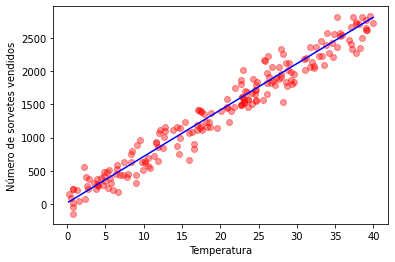

In [11]:
plt.plot(synt_x, synt_y, 'ro', alpha=0.4)
plt.xlabel("Temperatura")
plt.ylabel("Número de sorvetes vendidos")
plot_line(synt_x, synt_x * 70 + 15)
plt.show()

No gráfico podemos ver que: quanto mais quente -> mais sorventes são vedidos.

### Implementando Rede Neural

In [12]:
class NeuralNetwork(object):
    def __init__(self, layers=[1], input_size=1, activations=[None]):
        assert len(layers) == len(activations)
        self.input_size = input_size
        self.layers = layers
        self.activations, self._act_devs = self.get_act(activations)
        
        self.weights, self.biases = self.define_params()
        self._current_batch = []
        
    def get_act(self, act_names):
        def _no_act(x):
            return x
        def _dev_no_act(x):
            return np.ones(x.shape)

        def _sigmoid(x):
            return 1 / (1 + np.exp(-x))
        
        def _dev_sigmoid(x):
            return x * (1 - x)
        
        def _relu(x):
            return np.maximum(1e-15, x)
        
        def _dev_relu(x):
            return (x > 0) * 1.0
        
        activations = []
        act_devs = []
        for act_name in act_names:
            if act_name is None:
                act, dev_act = _no_act, _dev_no_act
            elif act_name == 'sigmoid':
                act, dev_act = _sigmoid, _dev_sigmoid
            elif act_name == 'relu':
                act, dev_act = _relu, _dev_relu
            else:
                raise ValueError('Activation function is not valid: %s' % act_name)
            
            activations.append(act)
            act_devs.append(dev_act)
        return activations, act_devs
    

    def define_params(self):
        '''He-et-all initialization'''
        weights = []
        biases = []
        for i, (in_dim, out_dim) in enumerate(zip([self.input_size] + self.layers, self.layers)):
            weights.append(np.random.randn(in_dim, out_dim) * np.sqrt(2/in_dim))
            biases.append(np.random.randn(out_dim) * np.sqrt(2/in_dim))           
            print('Weight %d shape =' % i, weights[i].shape)
            print('Bias %d shape =' % i, biases[i].shape)
            
        return weights, biases


    def update_params(self, gradients, learning_rate=0.1):
        assert len(gradients) == len(self.weights), (len(gradients), len(self.weights))
        assert len(gradients) == len(self.biases), (len(gradients), len(self.biases))
        
        for i, grad in enumerate(gradients[::-1]):
            assert grad['weights'].shape == self.weights[i].shape
            self.weights[i] -= learning_rate * grad['weights']
            self.biases[i] -= learning_rate * grad['biases']

    
    def run_batch(self, batch):
        self._current_batch = [batch]
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            output = np.dot(self._current_batch[-1], w) + b
            output = self.activations[i](output)
            self._current_batch.append(output)
        
        self._current_batch = self._current_batch[::-1]
        return output

### Implementando SGD

In [13]:
class Trainer(object):
    def __init__(self, model, learning_rate = 0.01, loss_name='l2',
                 print_mod=1000, verbose=True):
        
        def _accuracy(pred_y, real_y):
            print(pred_y, real_y)
            p = np.argmax(self.softmax(pred_y), axis=1)
            return np.sum(p == real_y) / len(pred_y)
            
        
        self.model = model
        self.loss_name = loss_name
        self.learning_rate = learning_rate
        self.loss, self.loss_dev = self._define_loss()
        
        self.train_step = 0
        self.eval_steps = []
        
        self.verbose = verbose
        self.print_mod = print_mod
        
        self.train_losses = []
        self.eval_losses = []
        
        self._metrics = {
            'accuracy': _accuracy
        }
    
    def softmax(self, x):
        exps = np.exp(x)
        return (exps / np.sum(exps, axis=1, keepdims=True))
        
    def _define_loss(self):
        def _l2(pred_y, real_y):
            return (1.0/2) * np.mean(np.power(pred_y - real_y, 2))
        
        def _l2_dev(pred_y, real_y):
            n = len(pred_y)
            return (pred_y - real_y) * (1.0/n)
        
        def _cross_entropy(pred_y, real_y):
            m = real_y.shape[0]
            p = self.softmax(pred_y)
            # We use multidimensional array indexing to extract 
            # softmax probability of the correct label for each sample.
            # Refer to https://docs.scipy.org/doc/numpy/user/basics.indexing.html#indexing-multi-dimensional-arrays for understanding multidimensional array indexing.
            log_likelihood = -np.log(p[range(m), real_y.astype(int)])
            loss = np.sum(log_likelihood) / m
            return loss
    
        
        def _cross_entropy_dev(pred_y, real_y):
            m = real_y.shape[0]
            grad = self.softmax(pred_y)
            grad[range(m), real_y.astype(int)] -= 1
            grad = grad / m
            return grad

        if self.loss_name == 'l2':
            return _l2, _l2_dev
        elif self.loss_name == 'cross-entropy':
            return _cross_entropy, _cross_entropy_dev
        else:
            raise ValueError('Invalid loss name: %s' % self.loss_name)


    def train(self, batch_x, batch_y):
        self.train_step += 1
        
        # run feed forward network
        pred_y = self.model.run_batch(batch_x)
        # save loss
        self.train_losses.append(self.loss(pred_y, batch_y))
        # get gradients
        grads = self.generate_gradients(pred_y, batch_y, batch_x)
        # update parameters
        self.model.update_params(grads, self.learning_rate)

        if self.verbose and (self.train_step - 1) % self.print_mod == 0:
            print('Loss: %.4f for step %d' % (self.train_losses[-1], self.train_step))


    def eval(self, batch_x, batch_y, metrics=[]):
        # run feed forward network
        pred_y = self.model.run_batch(batch_x)
        # loss
        loss = self.loss(pred_y, batch_y)
        self.eval_losses.append(loss)
        # metrics
        res_metrics = []
        for m in metrics:
            if m in self._metrics:
                res_metrics.append(self._metrics[m](pred_y, batch_y))
            else:
                raise ValueError('Invalid metric: %s' % m)
        
        self.eval_steps.append(self.train_step)
            
        return loss, res_metrics

    
    def plot_losses(self):
        if len(self.eval_losses) > 0:
            plt.title('Train Loss: %.4f | Test Loss: %.4f for step %d' % (self.train_losses[-1], self.eval_losses[-1], self.train_step))
        else:
            plt.title('Train Loss: %.4f for step %d' % (self.train_losses[-1], self.train_step))    
        plt.plot([i for i in range(self.train_step)], self.train_losses)
        plt.plot([i for i in self.eval_steps], self.eval_losses)
        
        
    def generate_gradients(self, pred_y, real_y, data_x):
        grad = []
        input_size = pred_y.shape[0]
        j = len(self.model.activations) - 1
        k = len(self.model.weights) - 1
        dly = self.loss_dev(pred_y, real_y) * self.model._act_devs[j](self.model._current_batch[0])
        dlx = np.dot(dly, self.model.weights[k].T)

        for i, (w, b) in enumerate(zip(self.model.weights[::-1], self.model.biases[::-1])):
            dlw = np.dot(self.model._current_batch[i+1].T, dly)
            dlb = np.sum(dly)
            # print('weight:', w.shape, 'bias:', b.shape)
            # print('dlw:', dlw.shape, 'dlb:', dlb.shape)
            # print('dly:', dly.shape, 'dlx:', dlx.shape)
            grad.append({
                'weights': dlw,
                'biases': dlb
            })
            
            j -= 1
            k -= 1
            if i != len(self.model.weights)-1:
                dly = dlx * self.model._act_devs[j](self.model._current_batch[i+1])
                dlx = np.dot(dly, self.model.weights[k].T)
        return grad

### Gradients

##### L2 loss with 1 layer, no activation

**Loss**

$$L = 1/2 * 1/n * \sum{(y_i - ŷ_i)^{2}}$$
$$L = 1/2 * 1/n * \sum{(y_i - w_i * x_i + b_i)^{2}}$$

**Gradients**

$$\frac{\partial L}{\partial w_i} = 1/2 * 1/n * 2 * \sum{(y_i - ŷ_i)} * \frac{\partial {ŷ_i}}{\partial w_i} $$
$$\frac{\partial L}{\partial w_i} = 1/n * \sum{(y_i - ŷ_i)} * x_i$$

---

$$\frac{\partial L}{\partial b_i} = 1/2 * 1/n * 2 * \sum{(y_i - ŷ_i)} * \frac{\partial {ŷ_i}}{\partial b_i} $$
$$\frac{\partial L}{\partial b_i} = 1/n * \sum{(y_i - ŷ_i)} * 1$$


##### L2 loss with 2 layers, relu activation in the hidden layer

**Loss**

$$L = 1/2 * 1/n * \sum{(y_i - ŷ_i)^{2}}$$
$$L = 1/2 * 1/n * \sum{(y_i - (w_j * x_j + b_j))^{2}}$$
$$x_j = relu(w_i * x_i + b_i)$$


**Gradients**

$$\frac{\partial L}{\partial w_i} = 1/n * \sum{(y_i - ŷ_i)} * x_j $$
$$\frac{\partial L}{\partial b_i} = 1/n * \sum{(y_i - ŷ_i)} * 1$$

$$\frac{\partial L}{\partial w_j} = 1/n * \sum{(y_i - ŷ_i)} * x_j * x_i, se relu() > 0$$
$$\frac{\partial L}{\partial b_j} = 1/n * \sum{(y_i - ŷ_i)} * x_j, se relu() > 0$$

### Treinando

Weight 0 shape = (1, 1)
Bias 0 shape = (1,)


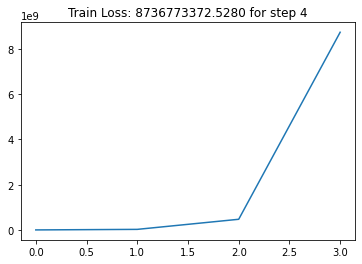

In [14]:
nn = NeuralNetwork()
t = Trainer(nn, verbose=False)
for i in range(4):
    t.train(synt_x, synt_y)

t.plot_losses()

#### Comparando com a realidade

Parâmetros aprendidos:
pesos: [array([[-24617.66749401]])]
bias: [array([-931.06023538])]
Função que modela os dados: 7 * X + 15


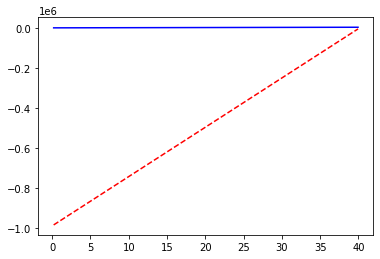

In [15]:
print('Parâmetros aprendidos:')
print('pesos:', nn.weights)
print('bias:', nn.biases)
print('Função que modela os dados: 7 * X + 15')
plot_line(synt_x, nn.run_batch(synt_x), '--r')
plot_line(synt_x, synt_y)
plt.show()


> ⚠️ **Cuidado: não confunda parâmetro com hiperparâmetros!** Parâmetros são o que a sua rede usa para aprender (pesos e bias), enquanto hiperparâmetros são o que você define acerca da sua rede (número de camadas, qtde. de neurônios por camada, função de ativação de cada camada, etc...)

### Uma função um pouco mais complicada

$Y = 7 * log(x) + 1$


In [16]:
SYNT_TRAIN_SIZE = 10

def get_random_error(size, mu=0, std_dev=0.8):
    return np.random.normal(mu, std_dev, size)

synt_x = np.random.rand(SYNT_TRAIN_SIZE)
synt_y = np.reshape(7 * np.log(synt_x) + 1 + get_random_error(SYNT_TRAIN_SIZE), (SYNT_TRAIN_SIZE, 1))

synt_x = np.reshape(synt_x, (SYNT_TRAIN_SIZE, 1))

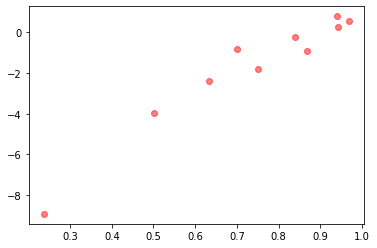

In [17]:
plt.plot(synt_x, synt_y, 'ro', alpha=0.5)

In [18]:
nn = NeuralNetwork(layers=[10, 1], activations=['sigmoid', None])
t = Trainer(nn)

Weight 0 shape = (1, 10)
Bias 0 shape = (10,)
Weight 1 shape = (10, 1)
Bias 1 shape = (1,)


Loss: 4.9900 for step 1
Loss: 1.6962 for step 1001
Loss: 0.3819 for step 2001
Loss: 0.1556 for step 3001
Loss: 0.1197 for step 4001
Loss: 0.1112 for step 5001
Loss: 0.1085 for step 6001
Loss: 0.1074 for step 7001
Loss: 0.1069 for step 8001
Loss: 0.1065 for step 9001


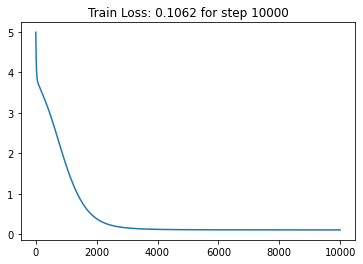

In [19]:
for i in range(10000):
    t.train(synt_x, synt_y)

t.plot_losses()

Parâmetros aprendidos:
pesos: [array([[-1.24047116,  0.83017039,  2.20806534, -2.31914135, -0.2588415 ,
         1.49421697, -6.23182752, -0.56248993, -3.92467563, -1.68246952]]), array([[-1.26115589],
       [ 0.60152667],
       [ 2.81026129],
       [-1.34532049],
       [-0.08108552],
       [ 1.20301932],
       [-7.42877675],
       [-0.80353124],
       [-4.34053156],
       [-1.2989495 ]])]
bias: [array([ 1.86182392, -0.53575689,  0.41346942, -0.27429696,  4.13800685,
        2.03944519,  2.60946168,  1.49228193,  1.3073641 , -0.47884765]), array([-1.47858784])]
Função que modela os dados: 7 * X + 15


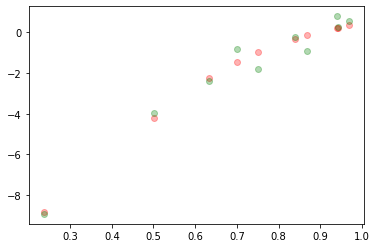

In [20]:
print('Parâmetros aprendidos:')
print('pesos:', nn.weights)
print('bias:', nn.biases)
print('Função que modela os dados: 7 * X + 15')
plt.plot(synt_x, nn.run_batch(synt_x), 'or', alpha=0.3)
plt.plot(synt_x, synt_y, 'og', alpha=0.3)
plt.show()

### E se os dados forem não lineares?

In [21]:
xor_x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
xor_y = np.array([[0], [1], [1], [0]])

Weight 0 shape = (2, 10)
Bias 0 shape = (10,)
Weight 1 shape = (10, 2)
Bias 1 shape = (2,)


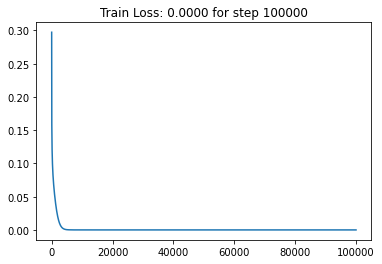

In [22]:
nn = NeuralNetwork(layers=[10, 2], input_size=2, activations=['relu', None])
t = Trainer(nn, verbose=False)
for i in range(100000):
    t.train(xor_x, xor_y)

t.plot_losses()

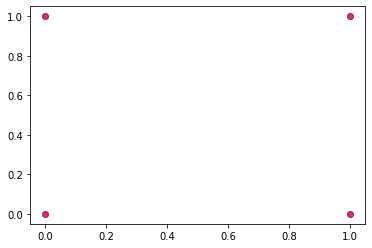

In [23]:
plt.plot(xor_x, nn.run_batch(xor_x), 'bo', xor_x, xor_y, 'ro', alpha=0.3)

Weight 0 shape = (2, 10)
Bias 0 shape = (10,)
Weight 1 shape = (10, 1)
Bias 1 shape = (1,)


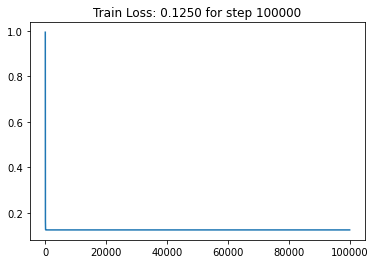

In [24]:
nn = NeuralNetwork(layers=[10, 1], input_size=2, activations=[None, None])
t = Trainer(nn, verbose=False)
for i in range(100000):
    t.train(xor_x, xor_y)

t.plot_losses()

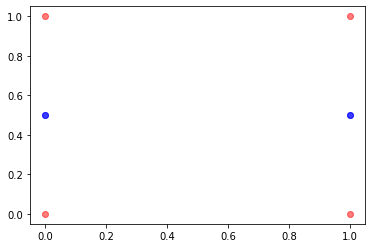

In [25]:
plt.plot(xor_x, nn.run_batch(xor_x), 'bo', xor_x, xor_y, 'ro', alpha=0.3)

## Base de dados Iris

A base de dados Iris foi publicada originalmente no [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/iris).

Uma das bases de dados mais conhecidas. É uma pequena base contendo informações sobre plantas de 3 diferentes espécies (setosa, versicolour e virginica). É bastante utilizada para classificação das espécies

* Atributos:
    1. sepal length in cm 
    2. sepal width in cm 
    3. petal length in cm 
    4. petal width in cm 
* Classes: 
    0. Iris Setosa 
    1. Iris Versicolour 
    2. Iris Virginica


### Obtendo os dados

In [28]:
# Carregar iris dataset
iris = fetch_openml('iris')
# np.c_ concatena as features e targets do dataset
iris_data = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                         columns=['x0', 'x1', 'x2', 'x3', 'target'])

/home/marianne/.local/lib/python3.6/site-packages/sklearn/datasets/_openml.py:407: UserWarning: Multiple active versions of the dataset matching the name iris exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]['version']))


In [29]:
iris_data.head()

,x0,x1,x2,x3,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5,3.6,1.4,0.2,Iris-setosa


In [32]:
iris_data.describe()

,x0,x1,x2,x3,target
count,150.0,150.0,150.0,150.0,150
unique,35.0,23.0,43.0,22.0,3
top,5.0,3.0,1.5,0.2,Iris-setosa
freq,10.0,26.0,14.0,28.0,50


In [35]:
iris_data.drop(['target'], axis=1).diff().hist(color='k', alpha=0.5, bins=10, figsize=(4, 5))
plt.show()

ValueError: hist method requires numerical columns, nothing to plot.

In [36]:
x = iris.data
y = iris.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [37]:
def batches(x, y, batch_size=True):
    idx = np.random.permutation(len(x))
    x = x[idx]
    y = y[idx]
    
    for i in range(0, len(x)-batch_size-1, batch_size):
        batch_x = x[i:i+batch_size]
        batch_y = y[i:i+batch_size]
        yield batch_x, batch_y

In [38]:
nn = NeuralNetwork(layers=[10, 4], input_size=4, activations=['relu', None])
t = Trainer(nn, verbose=False, loss_name='cross-entropy')
for i in range(1000):
    for batch_x, batch_y in batches(x, y, 16):
        t.train(batch_x, batch_y)
    if i % 10 == 0:
        loss, metrics = t.eval(x_test, y_test, metrics=['accuracy'])
        print('Test loss = %.5f, accuracy %.5f' % (loss, metrics[0]))

t.plot_losses()

Weight 0 shape = (4, 10)
Bias 0 shape = (10,)
Weight 1 shape = (10, 4)
Bias 1 shape = (4,)


KeyError: "None of [Int64Index([ 66,  11,  89, 132,  64, 113,  42,   5, 125,  25,\n            ...\n            146,  48, 103,  41,  99,  44, 127, 117,  34, 149],\n           dtype='int64', length=150)] are in the [columns]"

### MNIST

In [41]:
# load mnist
mnist = fetch_openml('MNIST original')

InvalidURL: URL can't contain control characters. '/api/v1/json/data/list/data_name/mnist original/limit/2/status/active/' (found at least ' ')

In [ ]:
x = mnist.data / np.max(mnist.data)
y = mnist.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [ ]:
nn = NeuralNetwork(layers=[512, 256, 10], input_size=784, activations=['relu', 'relu', None])
t = Trainer(nn, verbose=False, loss_name='cross-entropy', learning_rate=0.001)
for i in range(20):
    for batch_x, batch_y in batches(x, y, 64):
        t.train(batch_x, batch_y)
    if i % 1 == 0:
        loss, metrics = t.eval(x_test, y_test, metrics=['accuracy'])
        print('Test loss = %.5f, accuracy %.5f' % (loss, metrics[0]))

t.plot_losses()

## Referências

* [Blog do Matheus Facure sobre Gradiente Descendente (10/10)](https://matheusfacure.github.io/2017/02/20/MQO-Gradiente-Descendente/)